In [1]:
# Big Data Project Predictive Analytics Platformm

#Importing all the necessary modules

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, min as spark_min, max as spark_max, count
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import xml.etree.ElementTree as ET
import os

# Spark session
spark = SparkSession.builder.appName("GTFS_SIRI_Analytics 1").getOrCreate()


In [2]:
#Load GTFS timetable CSV files

DATA_PATH = "./dataset/gtfs/"  # <-- Update path
stops = spark.read.csv(os.path.join(DATA_PATH, "stops.txt"), header=True, inferSchema=True)
routes = spark.read.csv(os.path.join(DATA_PATH, "routes.txt"), header=True, inferSchema=True)
trips = spark.read.csv(os.path.join(DATA_PATH, "trips.txt"), header=True, inferSchema=True)
stop_times = spark.read.csv(os.path.join(DATA_PATH, "stop_times.txt"), header=True, inferSchema=True)
calendar = spark.read.csv(os.path.join(DATA_PATH, "calendar.txt"), header=True, inferSchema=True)
print("GTFS timetable loaded")


GTFS timetable loaded


In [3]:
#Parse SIRI-VM XML vehicle locations

SIRI_VM_PATH = "./dataset/location/siri.xml"  # <-- Update path
vm_tree = ET.parse(SIRI_VM_PATH)
vm_root = vm_tree.getroot()

vm_data = []
for vehicle in vm_root.findall('.//VehicleActivity'):
    vehicle_id = vehicle.findtext('.//VehicleRef')
    trip_id = vehicle.findtext('.//DatedVehicleJourneyRef')
    stop_id = vehicle.findtext('.//VehicleLocation/StopPointRef')
    lat = vehicle.findtext('.//VehicleLocation/Latitude')
    lon = vehicle.findtext('.//VehicleLocation/Longitude')
    timestamp = vehicle.findtext('.//RecordedAtTime')
    vm_data.append([vehicle_id, trip_id, stop_id, timestamp, lat, lon])

vm_df = pd.DataFrame(vm_data, columns=['vehicle_id','trip_id','stop_id','timestamp','latitude','longitude'])
print("SIRI-VM vehicle locations parsed")


SIRI-VM vehicle locations parsed


In [4]:
#Parse SIRI-SX disruptions XML

SIRI_SX_PATH = "./dataset/disruption/sirisx.xml"  # <-- Update path
sx_tree = ET.parse(SIRI_SX_PATH)
sx_root = sx_tree.getroot()

sx_data = []
for disruption in sx_root.findall('.//SituationExchangeDelivery/Disruption'):
    stop = disruption.findtext('.//AffectedStopPointRef')
    route = disruption.findtext('.//AffectedRouteRef')
    start = disruption.findtext('.//StartTime')
    end = disruption.findtext('.//EndTime')
    sx_data.append([stop, route, start, end])

sx_df = pd.DataFrame(sx_data, columns=["stop_id", "route_id", "start_time", "end_time"])
print("SIRI-SX disruptions parsed")


SIRI-SX disruptions parsed


In [5]:
# Data Cleaning

# GTFS stop_times
stop_times = stop_times.dropna(subset=["trip_id", "stop_id", "arrival_time"])

# Vehicle locations
vm_df.dropna(subset=["vehicle_id", "trip_id", "stop_id", "latitude", "longitude"], inplace=True)

# Disruptions
sx_df.dropna(subset=["stop_id", "route_id", "start_time", "end_time"], inplace=True)

In [16]:
# Delay prediction using disruptions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Sampling 10k rows for memory
stop_times_pd = stop_times.limit(10000).toPandas()
stop_times_pd['stop_id'] = stop_times_pd['stop_id'].astype(str)
sx_df['stop_id'] = sx_df['stop_id'].astype(str)

# Label delayed stops
stop_times_pd['delayed'] = stop_times_pd['stop_id'].isin(sx_df['stop_id'])

# Check class distribution
print("Class distribution:\n")
print(stop_times_pd['delayed'].value_counts())

# Features and target
X_delay = stop_times_pd[['trip_id']].apply(lambda x: x.astype('category').cat.codes)
y_delay = stop_times_pd['delayed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_delay.values.reshape(-1, 1), y_delay, test_size=0.2, random_state=42
)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)


# Metrics

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

print("\nDelay Prediction Metrics \n")
print(f"Accuracy : {accuracy:.2f}\n")

# Only compute classification metrics if both classes exist
if len(set(y_test)) > 1:

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Precision: {precision:.2f}")
    print(f"Recall   : {recall:.2f}")
    print(f"F1-score : {f1:.2f}")

    # ROC AUC requires probability + two classes
    if len(rf.classes_) == 2:
        y_proba = rf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)

        print(f"ROC AUC  : {roc_auc:.2f}")

        # ROC curve plot
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for Delay Prediction")
        plt.legend()
        plt.show()

else:
    print("ROC AUC and curve not available: there is only one class in training data.")
    print("No delayed trips found in the sample. Cannot compute metrics. Precision, Recall, F1-score, and ROC AUC are not meaningful.")


Class distribution:

delayed
False    10000
Name: count, dtype: int64

Delay Prediction Metrics 

Accuracy : 1.00

ROC AUC and curve not available: there is only one class in training data.
No delayed trips found in the sample. Cannot compute metrics. Precision, Recall, F1-score, and ROC AUC are not meaningful.


Travel Time Prediction MAE: 17.71 minutes


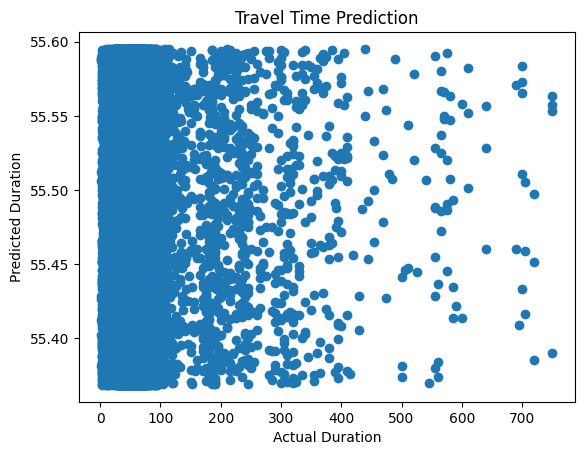

In [8]:
# Travel time prediction (Linear Regression)

trip_features_pd = trip_duration.select("duration_minutes").dropna().toPandas()
X = trip_features_pd.index.values.reshape(-1, 1)
y = trip_features_pd['duration_minutes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Travel Time Prediction MAE: {mae:.2f} minutes")

plt.figure()
plt.scatter(y_test, predictions)
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Travel Time Prediction")
plt.show()


In [9]:
#Delay prediction using disruptions


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Sample 10k rows for memory
stop_times_pd = stop_times.limit(10000).toPandas()
stop_times_pd['stop_id'] = stop_times_pd['stop_id'].astype(str)
sx_df['stop_id'] = sx_df['stop_id'].astype(str)

# Label delayed stops
stop_times_pd['delayed'] = stop_times_pd['stop_id'].isin(sx_df['stop_id'])

# Check class distribution
print("Class distribution:\n")
print(stop_times_pd['delayed'].value_counts())

# Only proceed if both classes exist
if len(stop_times_pd['delayed'].unique()) > 1:
    # Features and target
    X_delay = stop_times_pd[['trip_id']].apply(lambda x: x.astype('category').cat.codes)
    y_delay = stop_times_pd['delayed']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_delay.values.reshape(-1,1), y_delay, test_size=0.2, random_state=42, stratify=y_delay
    )

    # Random Forest model
    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)

    # Predictions
    y_pred = rf.predict(X_test)

    # Compute probabilities if two classes exist
    if len(rf.classes_) == 2:
        y_proba = rf.predict_proba(X_test)[:,1]
    else:
        y_proba = None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print("\n=== Delay Prediction Metrics ===")
    print(f"Accuracy : {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall   : {recall:.2f}")
    print(f"F1-score : {f1:.2f}")

    # ROC Curve
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC  : {roc_auc:.2f}")

        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve for Delay Prediction")
        plt.legend()
        plt.show()
    else:
        print("ROC AUC and curve not available:  there is only one class in training data.")

else:
    print("No delayed trips found in the sample. Cannot compute metrics.")









Class distribution:

delayed
False    10000
Name: count, dtype: int64
No delayed trips found in the sample. Cannot compute metrics.


C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


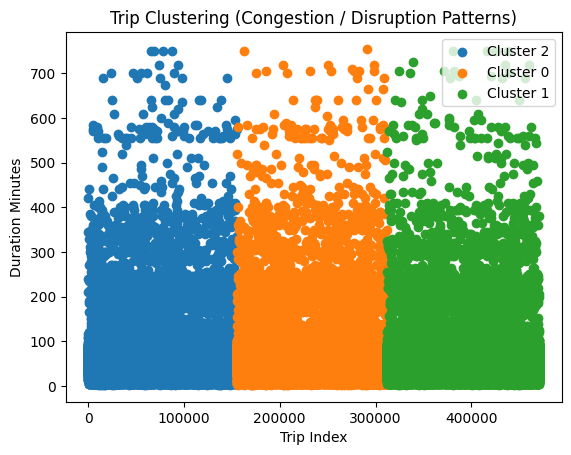

In [34]:
#Congestion / disruption clustering (K-Means)

trip_features_pd['trip_index'] = trip_features_pd.index
kmeans = KMeans(n_clusters=3, random_state=42)
trip_features_pd['cluster'] = kmeans.fit_predict(trip_features_pd[['duration_minutes','trip_index']])


plt.figure()
for c in trip_features_pd['cluster'].unique():
    cluster_data = trip_features_pd[trip_features_pd['cluster']==c]
    plt.scatter(cluster_data['trip_index'], cluster_data['duration_minutes'], label=f"Cluster {c}")
plt.xlabel("Trip Index")
plt.ylabel("Duration Minutes")
plt.title("Trip Clustering (Congestion / Disruption Patterns)")
plt.legend()
plt.show()

In [11]:
# Save outputs

trips_hour_pd.to_csv("peak_hours.csv", index=False)
trip_features_pd.to_csv("trip_durations_clusters.csv", index=False)
vm_df.to_csv("vehicle_locations.csv", index=False)
sx_df.to_csv("disruptions.csv", index=False)
print("All outputs saved")


All outputs saved


In [ ]:
# # Stop Spark session
# spark.stop()
# print("Spark session stopped")